In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

import time
import os

from sklearn.metrics import roc_curve, auc
from scipy.cluster import hierarchy
from sklearn.metrics import f1_score
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

In [2]:
color_path = '/fh/fast/ha_g/user/adoebley/data/SCLC_cfDNA_metadata/metadata_table/metadata_from_joe/221117.color_map.csv'
metadata_path = '/fh/fast/ha_g/user/adoebley/data/SCLC_cfDNA_metadata/metadata_table/metadata_from_joe/SCLC_key_metadata_2023-01-05.tsv'
in_dir = 'results_v4'
out_dir = 'figures_v4'
table_dir = 'tables_v4'
outfile_name = 'selected_classifier_results_2023-10-15.tsv'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [3]:
#import color dict
color_dict = pd.read_csv(color_path, keep_default_na = False)
color_dict = color_dict.set_index('label')['namedcolor'].to_dict()
color_dict['REST'] = 'tab:grey'

cmap = matplotlib.cm.get_cmap('viridis')
color_dict['positive'] = matplotlib.colors.rgb2hex(cmap(1.0))
color_dict['focal'] = matplotlib.colors.rgb2hex(cmap(0.5))
color_dict['negative'] = matplotlib.colors.rgb2hex(cmap(0.0))

color_dict['ASCL1+ATOH1+NEUROD1'] = 'tab:brown'
color_dict['High'] = matplotlib.colors.rgb2hex(cmap(1.0))
color_dict['Low'] = matplotlib.colors.rgb2hex(cmap(0.0))
color_dict['NA'] = 'white'
color_dict['Unknown'] = 'white'
color_dict['Unknown/NA'] = 'white'

order = ['ASCL1', 'ASCL1+NEUROD1', 'NEUROD1','ATOH1+NEUROD1','ATOH1', 'POU2F3', 'Pan-low', 'Unknown', 'NA']
analysis_order = ['ASCL1', 'NEUROD1','ATOH1', 'POU2F3','REST']
analysis_order2 = [m for m in analysis_order if not m == 'REST']
prediction_cols = ['s_hat.'+m for m in analysis_order]
RNA_cols = analysis_order

null_labels = ['NA','Unknown']

In [4]:
#import metadata
def import_metadata(metadata_path):
    metadata = pd.read_csv(metadata_path, sep='\t', keep_default_na = False)
    metadata = metadata.replace('',np.nan)
    metadata = metadata[(metadata['sequencing_type']=='targeted')]
    metadata = metadata[(metadata[['protocol_pass', 'coverage_pass', 'other_pass']]=='pass').all(axis = 1)]

    metadata = metadata.set_index('sample')

    metadata['subtype'] = metadata['subtype'].replace(np.nan,'NA')
    
    #define REST activity
    metadata['REST-activity'] = metadata['REST_status'].replace(np.nan,'NA')
    
    for TF in ['ASCL1','NEUROD1','POU2F3','ATOH1']:
        #new version!
        metadata[TF+'-activity'] = np.where(metadata['subtype'].str.contains(TF),'High','Low')
        metadata[TF+'-activity'] = np.where(metadata['subtype'].isin(['NA','Unknown']),'Unknown',metadata[TF+'-activity'])
        metadata[TF+'-activity'] = np.where(metadata['histology'].isin(['LUAD','LUSC']),'Low',metadata[TF+'-activity'])  

    #drop ATOH1 activity for the MSK samples without ATOH1 data
    metadata['ATOH1-activity'] = np.where((metadata['ATOH1'].isnull()) & (metadata['histology']=='SCLC'), 'Unknown', metadata['ATOH1-activity'])
    
    return(metadata)

metadata = import_metadata(metadata_path)
print('samples:',len(metadata))

samples: 135


In [5]:
#set up finalized analysis dict
def make_analysis_dict():
    analysis_dict = {'SCLC-v-NSCLC':
                     {'target_column':'histology',
                     'pos_phenos':['SCLC'],
                     'training_histologies':['SCLC','LUAD','LUSC'],
                     'feature_set':'TFBS-TSS-SCLC-v-NSCLC-allcols'
                     }}

    for TF in ['ASCL1','NEUROD1','POU2F3','ATOH1','REST']:
        analysis_dict[TF] = {'target_column':TF+'-activity',
                     'pos_phenos':['High'],
                     'training_histologies':['SCLC','LCNEC'],
                     'feature_set':'TFBS-TSS-SCLCsub-'+TF+'-allcols'
                            }

    best_feature_sets = {}
    for key in analysis_dict.keys():
        best_feature_sets[key] = analysis_dict[key]['feature_set']
    return(analysis_dict,best_feature_sets)

analysis_dict,best_feature_sets = make_analysis_dict()

In [6]:
#import results
def import_results(in_dir):
    results = pd.DataFrame()

    for item in os.listdir(in_dir):
        if item.startswith('.'):
            continue
        if item.startswith('selected_classifier_results'):
            continue
        listy = item.split('_')

        result_type = listy[-1].split('.')[0]
        analysis = listy[0]
        feature_set = listy[1]

        if feature_set in best_feature_sets.values():
            current_data = pd.read_csv(in_dir+'/'+item, sep='\t', keep_default_na = False)
            current_data['result_type'] = result_type
            current_data['analysis'] = analysis
            current_data['feature_set'] = feature_set
            #current_data['fixed_a'] = current_data['fixed_a'].astype(float)
            results = results.append(current_data)

    #merge with metadata and feature order
    results = results.merge(metadata, on = 'sample').reset_index(drop = True)
    
    return(results)

selected_results = import_results(in_dir)
selected_results.to_csv(table_dir+'/'+outfile_name, sep='\t', index = False)

In [7]:
print(selected_results['analysis'].value_counts())
print(len(selected_results['sample'].unique()))

NEUROD1         135
SCLC-v-NSCLC    135
POU2F3          135
ASCL1           135
REST            135
ATOH1           135
Name: analysis, dtype: int64
135


In [8]:
def interpolate_threshold(df2,target_column, pos_phenos): 
    interp_fprs = []
    interp_tprs = []
    interp_f1 = []
    
    spaced_thresholds = np.arange(0,1.01,0.01)

    for threshold in spaced_thresholds:

        y_true = np.where(df2[target_column].isin(pos_phenos),1,0)
        y_pred = np.where(df2['s_hat']>=threshold,1,0)

        interp_fprs.append( np.where((y_true==0) & (y_pred == 1), 1, 0).sum()/len(y_true[y_true==0]) ) 
        interp_tprs.append( np.where((y_true==1) & (y_pred == 1), 1, 0).sum()/len(y_true[y_true==1]) )

        interp_f1.append(f1_score(y_true, y_pred))

    #interp_j = np.array(interp_tprs) - np.array(interp_fprs) #Youden’s J statistic
    interp_stats = pd.DataFrame([spaced_thresholds, interp_fprs, interp_tprs, interp_f1], index = ['threshold','fpr','tpr','f1']).T

    return(interp_stats)


{'SCLC-v-NSCLC': 0.49}

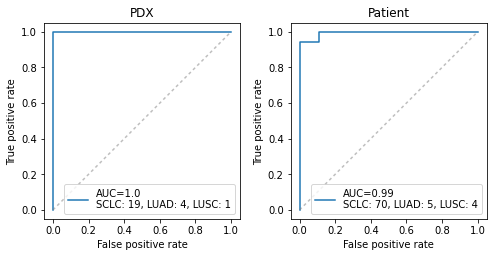

In [9]:
#this figure is not used, only the thresholds
def AUC_plots_analysis_NSCLC(selected_results):
    fig,ax = plt.subplots(1,2, figsize = (7,4))
    threshold_dict = {}
    for analysis in ['SCLC-v-NSCLC']:
        df1 = selected_results[(selected_results['analysis']==analysis)]
        
        target_column = analysis_dict[analysis]['target_column']
        pos_phenos = analysis_dict[analysis]['pos_phenos']
        test_hist = analysis_dict[analysis]['training_histologies']
     
        df1 = df1[(df1['histology'].isin(test_hist))] #this removes the HDs
        df1 = df1[~(df1[target_column].isin(null_labels))].copy()

        #for PDX or patients
        for i,(result_type,source) in enumerate(zip(['training','test'],['PDX','Patient'])):
            df2 = df1[df1['result_type']==result_type]
            assert len(df2) == len(df2['sample'].unique()), 'wrongs samples'
            
            fpr, tpr, _ = roc_curve(np.where(df2[target_column].isin(pos_phenos),1,0),df2['s_hat'])
            roc_auc = np.round(auc(fpr,tpr),2)
            counts_text = df2[target_column].value_counts().to_dict()
            counts_text = [': '.join([key,str(value)]) for key,value in counts_text.items()]
            counts_text = (', ').join(counts_text)
            counts_text = str(counts_text)
            ax[i].plot(fpr,tpr, label = 'AUC='+str(roc_auc)+'\n'+counts_text)

            if source == 'PDX':
                interp_stats = interpolate_threshold(df2,target_column, pos_phenos)
                best_threshold = np.round(interp_stats[interp_stats['f1']==interp_stats['f1'].max()]['threshold'].median(),2)        
                threshold_dict[analysis] = best_threshold
            
            ax[i].set_title(source)

            ax[i].set_xlabel('False positive rate')
            ax[i].set_ylabel('True positive rate')
            ax[i].plot([0,1],[0,1], color = 'tab:grey', dashes = [2,2], alpha = 0.5)
            ax[i].set_aspect(1.0/ax[i].get_data_ratio(), adjustable='box')
            ax[i].legend(loc = 'lower right')        

        fig.tight_layout()
        fig.savefig(out_dir+'/SCLC_v_NSCLC_best_feats.AUC.pdf')
        fig.show()
        return(threshold_dict)
        
threshold_dict_NSCLC = AUC_plots_analysis_NSCLC(selected_results[selected_results['tumor_fraction']>=0.05])
threshold_dict_NSCLC

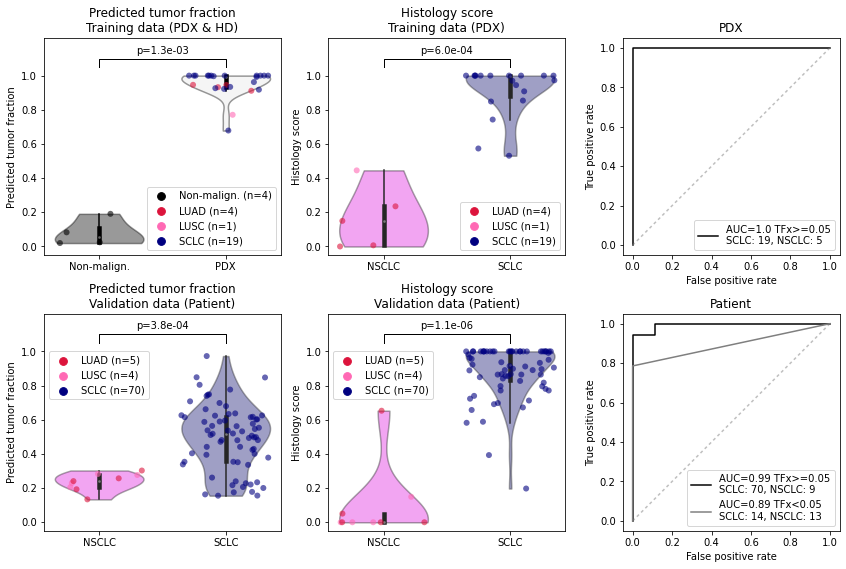

In [10]:
def make_NSCLC_scatter_v3(selected_results,threshold):
    fig,axes = plt.subplots(2,3, figsize = (12,8))

    width = .7 #violin width
    dot_size = 6
    jitter = 0.35
    np.random.seed(125) #set the random seed for the jitter


    df1 = selected_results[selected_results['analysis']=='SCLC-v-NSCLC']
    df1 = df1[~(df1['histology']=='LCNEC')]
    #df1 = df1[(df1['tumor_fraction']>=0.05) | (df1['histology']=='Non-malign.')]
    df1 = df1.copy()
    df1['group'] = df1['histology'].replace('LUSC','NSCLC').replace('LUAD','NSCLC')
    df1['source'] = np.where(df1['histology']=='Non-malign.',df1['histology'],df1['source'])

    ylabel_dict = {'a_hat':'Predicted tumor fraction','s_hat':'Histology score'}
    source_label_dict = {'Non-malign.':'Non-malign.','pdx':'PDX','patient':'Patient'}

    #PDX and HD tumor fraction violin plot############################
    df2 = df1[(df1['source']=='pdx') | (df1['histology']=='Non-malign.')]
    metric = 'a_hat'
    ax = axes[0,0]

    box_order = ['Non-malign.', 'pdx']
    box_colors = ['0.0', '0.9']

    scatter_order = ['Non-malign.','LUAD','LUSC','SCLC']
    scatter_colors = [color_dict[m] for m in scatter_order]

    sns.violinplot(x = df2['source'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
    plt.setp(ax.collections, alpha=.4)
    sns.stripplot(x = df2['source'], y = df2[metric], hue = df2['histology'], ax = ax,
                  size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                  hue_order = scatter_order, palette = scatter_colors)

    #add stats
    a = df2[df2['source']=='pdx'][metric]
    b = df2[df2['source']=='Non-malign.'][metric]
    statistic, pval = mannwhitneyu(a,b)
    formatted_pval = 'p={:.1e}'.format(pval)
    ax.annotate(formatted_pval,[0.5,1.13], ha='center')
    ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
    del(statistic,pval,formatted_pval)

    #format plot
    counts = df2['histology'].value_counts().to_dict()
    handles, labels = ax.get_legend_handles_labels()
    labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
    ax.legend(handles,labels,loc = 'lower right')
    ax.set_ylim(-0.05,1.22)
    ax.set_ylabel(ylabel_dict[metric])
    ax.set_xlabel('')
    ax.set_xticklabels([source_label_dict[m] for m in box_order])
    ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.set_title(ylabel_dict[metric]+'\nTraining data (PDX & HD)')
    del(df2)
    ##################################################################

    #PDX SCLC fraction violin plot####################################
    df2 = df1[(df1['source']=='pdx')]
    metric = 's_hat'
    ax = axes[0,1]

    box_order = ['NSCLC', 'SCLC']
    box_colors = [color_dict[m] for m in box_order]

    scatter_order = ['LUAD','LUSC','SCLC']
    scatter_colors = [color_dict[m] for m in scatter_order]

    sns.violinplot(x = df2['group'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
    plt.setp(ax.collections, alpha=.4)
    sns.stripplot(x = df2['group'], y = df2[metric], hue = df2['histology'], ax = ax,
                  size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                  hue_order = scatter_order, palette = scatter_colors)

    #add stats
    a = df2[df2['group']=='NSCLC'][metric]
    b = df2[df2['group']=='SCLC'][metric]
    statistic, pval = mannwhitneyu(a,b)
    formatted_pval = 'p={:.1e}'.format(pval)
    ax.annotate(formatted_pval,[0.5,1.13], ha='center')
    ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
    del(statistic,pval,formatted_pval)

    #format plot
    counts = df2['histology'].value_counts().to_dict()
    handles, labels = ax.get_legend_handles_labels()
    labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
    ax.legend(handles,labels,loc = 'lower right')
    ax.set_ylim(-0.05,1.22)
    ax.set_ylabel(ylabel_dict[metric])
    ax.set_xlabel('')
    ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.set_title(ylabel_dict[metric]+'\nTraining data (PDX)')
    del(df2)
    ##################################################################


    #Patient tumor fraction violin plot###############################
    df2 = df1[(df1['source']=='patient') & (df1['tumor_fraction']>0.05)]
    metric = 'a_hat'
    ax = axes[1,0]

    box_order = ['NSCLC', 'SCLC']
    box_colors = [color_dict[m] for m in box_order]

    scatter_order = ['LUAD','LUSC','SCLC']
    scatter_colors = [color_dict[m] for m in scatter_order]

    sns.violinplot(x = df2['group'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
    plt.setp(ax.collections, alpha=.4)
    sns.stripplot(x = df2['group'], y = df2[metric], hue = df2['histology'], ax = ax,
                  size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                  hue_order = scatter_order, palette = scatter_colors)

    #add stats
    a = df2[df2['group']=='NSCLC'][metric]
    b = df2[df2['group']=='SCLC'][metric]
    statistic, pval = mannwhitneyu(a,b)
    formatted_pval = 'p={:.1e}'.format(pval)
    ax.annotate(formatted_pval,[0.5,1.13], ha='center')
    ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
    del(statistic,pval,formatted_pval)

    #format plot
    counts = df2['histology'].value_counts().to_dict()
    handles, labels = ax.get_legend_handles_labels()
    labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
    ax.legend(handles,labels,loc = 'upper left', bbox_to_anchor = [0,.85])
    ax.set_ylim(-0.05,1.22)
    ax.set_ylabel(ylabel_dict[metric])
    ax.set_xlabel('')
    ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.set_title(ylabel_dict[metric]+'\nValidation data (Patient)')
    del(df2)
    ##################################################################

    #Patient SCLC fraction violin plot################################
    df2 = df1[(df1['source']=='patient') & (df1['tumor_fraction']>0.05)]
    metric = 's_hat'
    ax = axes[1,1]

    box_order = ['NSCLC', 'SCLC']
    box_colors = [color_dict[m] for m in box_order]

    scatter_order = ['LUAD','LUSC','SCLC']
    scatter_colors = [color_dict[m] for m in scatter_order]

    sns.violinplot(x = df2['group'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
    plt.setp(ax.collections, alpha=.4)
    sns.stripplot(x = df2['group'], y = df2[metric], hue = df2['histology'], ax = ax,
                  size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                  hue_order = scatter_order, palette = scatter_colors)

    #add stats
    a = df2[df2['group']=='NSCLC'][metric]
    b = df2[df2['group']=='SCLC'][metric]
    statistic, pval = mannwhitneyu(a,b)
    formatted_pval = 'p={:.1e}'.format(pval)
    ax.annotate(formatted_pval,[0.5,1.13], ha='center')
    ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
    del(statistic,pval,formatted_pval)

    #format plot
    counts = df2['histology'].value_counts().to_dict()
    handles, labels = ax.get_legend_handles_labels()
    labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
    ax.legend(handles,labels,loc = 'upper left', bbox_to_anchor = [0,.85])
    ax.set_ylim(-0.05,1.22)
    ax.set_ylabel(ylabel_dict[metric])
    ax.set_xlabel('')
    ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
    ax.set_yticks(np.arange(0,1.01,0.2))
    ax.set_title(ylabel_dict[metric]+'\nValidation data (Patient)')
    del(df2)
    ##################################################################

    #AUC plots
    #for PDX or patients
    analysis = 'SCLC-v-NSCLC'
    target_column = analysis_dict[analysis]['target_column']
    pos_phenos = analysis_dict[analysis]['pos_phenos']
    test_hist = analysis_dict[analysis]['training_histologies']

    for i,(result_type,source) in enumerate(zip(['training','test'],['PDX','Patient'])):
        ax = axes[i,2]
        df2 = df1[(df1['histology'].isin(test_hist)) #this removes the HDs and LCNEC
                  & (df1['result_type']==result_type) #this limits to either pdx or patient
                  & (df1['tumor_fraction']>=0.05)] 
        assert len(df2) == len(df2['sample'].unique()), 'wrongs samples'

        fpr, tpr, _ = roc_curve(np.where(df2[target_column].isin(pos_phenos),1,0),df2['s_hat'])
        roc_auc = np.round(auc(fpr,tpr),2)
        counts_text = df2['group'].value_counts().to_dict()
        counts_text = [': '.join([key,str(value)]) for key,value in counts_text.items()]
        counts_text = (', ').join(counts_text)
        counts_text = str(counts_text)
        ax.plot(fpr,tpr, label = 'AUC='+str(roc_auc)+' TFx>=0.05\n'+counts_text, color = 'black')
        
        del(df2,fpr,tpr,roc_auc,counts_text)
        
        #add low tfx 
        if source == 'Patient':
            df2 = df1[(df1['histology'].isin(test_hist)) #this removes the HDs and LCNEC
                      & (df1['result_type']==result_type) #this limits to either pdx or patient
                      & (df1['tumor_fraction']<0.05)] 
            assert len(df2) == len(df2['sample'].unique()), 'wrongs samples'
            
            fpr, tpr, _ = roc_curve(np.where(df2[target_column].isin(pos_phenos),1,0),df2['s_hat'])
            roc_auc = np.round(auc(fpr,tpr),2)
            counts_text = df2['group'].value_counts().to_dict()
            counts_text = [': '.join([key,str(value)]) for key,value in counts_text.items()]
            counts_text = (', ').join(counts_text)
            counts_text = str(counts_text)
            ax.plot(fpr,tpr, label = 'AUC='+str(roc_auc)+' TFx<0.05 \n'+counts_text, color = 'tab:grey')
            
            del(df2,fpr,tpr,roc_auc,counts_text)

        #format it
        ax.set_title(source)
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
        ax.plot([0,1],[0,1], color = 'tab:grey', dashes = [2,2], alpha = 0.5)
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        ax.legend(loc = 'lower right')       

    fig.tight_layout()
    fig.savefig(out_dir+'/SCLC_NSCLC_scatter.v3.pdf')

make_NSCLC_scatter_v3(selected_results,threshold_dict_NSCLC['SCLC-v-NSCLC'])


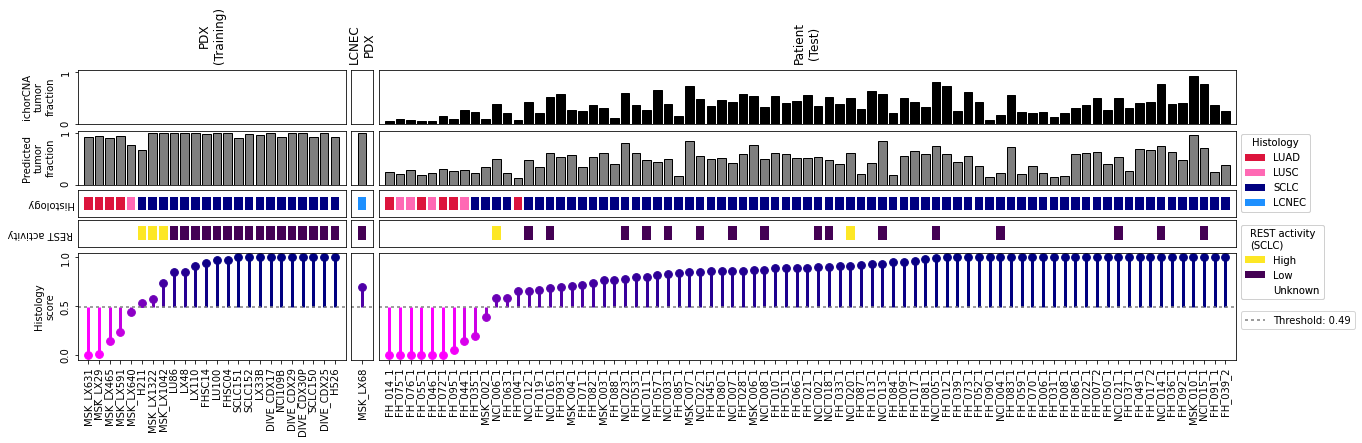

In [11]:
# threshold = threshold_dict_NSCLC['SCLC-v-NSCLC']
#SCLC NSCLC fig
def SCLC_NSCLC_bar_plot_v2(selected_results,threshold):
    title_dict = {'training':'PDX\n(Training)','PDX-test':'LCNEC\nPDX','test':'Patient\n(Test)'}
    cmap = LinearSegmentedColormap.from_list('', [color_dict['NSCLC'],color_dict['SCLC']])
    hist_legend_elements = {}
    REST_legend_elements = {}

    df1 = selected_results[selected_results['analysis']=='SCLC-v-NSCLC']
    df1 = df1[~(df1['histology']=='Non-malign.') & (df1['tumor_fraction']>=0.05)]

    df1 = df1.sort_values(by = 'source', ascending = False)

    fig,axes = plt.subplots(5, df1.groupby(['result_type'], sort = False).size().shape[0]+1, figsize=(20,6), 
                              gridspec_kw={'height_ratios':[1, 1, 0.5, 0.5, 2], 
                                  'width_ratios':list(df1.groupby(['result_type'],sort = False).size().values+1)+[8]},
                                       constrained_layout=True , sharex = 'col', sharey = 'row')

    for j in range(axes.shape[0]): #remove the extra ax that is making space for the legend
        fig.delaxes(axes[j,-1])
        
    for i,(result_type,df2) in enumerate(df1.groupby('result_type', sort = False)):
        df2 = df2.sort_values(by = 's_hat').copy()

        for j in range(axes.shape[1]+1):
            axes[j,i].tick_params(bottom = False,  labelbottom = False, left = False, labelleft = False)
            
        #tumor fraction
        j = 0
        ax = axes[j,i]
        ax.set_xlim(-1,len(df2))
        ax.set_ylim(0,1.05)
        if result_type == 'test':
            ax.bar(df2['sample_name'], df2['tumor_fraction'], color = 'black', edgecolor = 'black')
        axes[j,0].tick_params(left = True, labelleft = True)
        yticks = [0,1]
        axes[j,0].set_yticks(yticks)
        axes[j,0].set_yticklabels(yticks, rotation = 90, va = 'center')
        axes[j,0].set_ylabel('ichorCNA\ntumor\nfraction', rotation = 90, labelpad=5, va='bottom', ha='center')

        ax.set_title(title_dict[result_type], rotation = 90, va = 'bottom', ha = 'center')
        
        #predicted tumor fraction
        j+=1
        axes[j,i].set_ylim(0,1.05)
        axes[j,i].bar(df2['sample_name'], df2['a_hat'], color = 'tab:grey', edgecolor = 'black')
        axes[j,0].set_ylabel('Predicted\ntumor\nfraction', rotation = 90, labelpad=5, va='bottom', ha='center')
        axes[j,0].tick_params(left = True, labelleft = True, rotation = 90)

        #histology
        j+=1
        for histology,df3 in df2.groupby('histology'):
            axes[j,i].bar(df3['sample_name'], np.ones(len(df3)), color = color_dict[histology], label = histology)
        handles,labels = axes[j,i].get_legend_handles_labels()
        new_hist_legend_elements = dict(zip(labels, handles))
        hist_legend_elements.update(new_hist_legend_elements)
        if i == axes.shape[1]-2: #if it is the second to last axis, make the legend
            hist_legend = axes[j,i].legend(hist_legend_elements.values(), hist_legend_elements.keys(), bbox_to_anchor = [1,0], loc = 'lower left', title = 'Histology')
            axes[j,i].add_artist(hist_legend)
        axes[j,i].set_ylim(-0.5,1.5)
        axes[j,0].set_ylabel('Histology', rotation = 180, labelpad=5, va='center', ha='left')

        #REST activity
        j+=1
        for (histology,activity),df3 in df2.groupby(['histology','REST-activity']):
            if histology in ['SCLC','LCNEC']:
                axes[j,i].bar(df3['sample_name'], np.ones(len(df3)), color = color_dict[activity], label = activity)
        handles,labels = axes[j,i].get_legend_handles_labels()
        new_REST_legend_elements = dict(zip(labels, handles))
        REST_legend_elements.update(new_REST_legend_elements)
        if i == axes.shape[1]-2: #if it is the second to last axis, make the legend
            REST_legend = axes[j,i].legend(REST_legend_elements.values(), REST_legend_elements.keys(), bbox_to_anchor = [1,1], loc = 'upper left', title = 'REST activity\n(SCLC)')
            axes[j,i].add_artist(REST_legend)
        axes[j,i].set_ylim(-0.5,1.5)
        axes[j,0].set_ylabel('REST activity', rotation = 180, labelpad=5, va='center', ha='left')

        #prediction
        j+=1
        ax = axes[j,i]
        for k in range(len(df2)):
            rgba = cmap(df2.iloc[k]['s_hat'])
            ax.plot([k,k],[threshold,df2.iloc[k]['s_hat']], color = rgba, solid_capstyle='butt', linewidth = 3)
            ax.scatter([k],[df2.iloc[k]['s_hat']], color = rgba, s = 60)
        ax.axhline(threshold, color = 'tab:grey', dashes = (2,2), label = 'Threshold: '+str(threshold))
        ax.tick_params(axis = 'x', rotation=90, bottom = True,  labelbottom = True)
        axes[j,0].set_ylabel('Histology\nscore', rotation = 90, labelpad=5, va='bottom', ha='center')
        yticks = np.arange(0,1.1,0.5)
        axes[j,0].set_yticks(yticks)
        axes[j,0].set_yticklabels(yticks, rotation = 90, va = 'center')
        axes[j,0].tick_params(left = True, labelleft = True, rotation = 90)
        axes[j,i].tick_params(bottom = True,  labelbottom = True) #add sample labels to last axis
        if i == axes.shape[1]-2:
            axes[j,i].legend(bbox_to_anchor = [1,.5], loc = 'upper left')


    fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.02, hspace=0, wspace=0)
    
    fig.savefig(out_dir+'/sclc_nsclc_bar.v2.pdf')
    
SCLC_NSCLC_bar_plot_v2(selected_results,threshold_dict_NSCLC['SCLC-v-NSCLC'])


SCLC

{'ASCL1': 0.55, 'NEUROD1': 0.36, 'ATOH1': 0.6, 'POU2F3': 0.38, 'REST': 0.43}

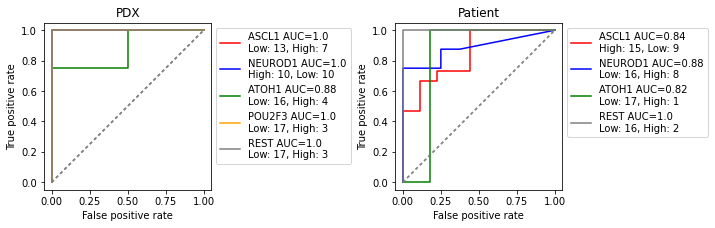

In [12]:
def SCLC_AUC_plots_analysis(selected_results):
    fig,ax = plt.subplots(1,2, figsize = (10,4), squeeze = False)
    threshold_dict = {}
    for analysis in analysis_order:       
        df1 = selected_results[(selected_results['analysis']==analysis)]

        target_column = analysis_dict[analysis]['target_column']
        pos_phenos = analysis_dict[analysis]['pos_phenos']
        test_hist = analysis_dict[analysis]['training_histologies']

        df1 = df1[(df1['histology'].isin(test_hist))] #this removes the HDs
        df1 = df1[~(df1[target_column].isin(null_labels))].copy()

        #for PDX or patients
        for i,(result_type,source) in enumerate(zip(['training','test'],['PDX','Patient'])):
            df2 = df1[df1['result_type']==result_type]
            assert len(df2) == len(df2['sample'].unique()), 'wrongs samples'
            if len(df2[target_column].unique())==1:
                continue
                
            fpr, tpr, thresholds = roc_curve(np.where(df2[target_column].isin(pos_phenos),1,0),df2['s_hat'])

            if source == 'PDX':
                interp_stats = interpolate_threshold(df2,target_column, pos_phenos)
                best_threshold = np.round(interp_stats[interp_stats['f1']==interp_stats['f1'].max()]['threshold'].median(),2)        
                threshold_dict[analysis] = best_threshold

            roc_auc = np.round(auc(fpr,tpr),2)
            counts_text = df2[target_column].value_counts().to_dict()
            counts_text = [': '.join([key,str(value)]) for key,value in counts_text.items()]
            counts_text = (', ').join(counts_text)
            counts_text = str(counts_text)
            ax[0,i].plot(fpr,tpr, color = color_dict[analysis], 
                       label = analysis+' AUC='+str(roc_auc)+'\n'+counts_text)

            ax[0,i].set_title(source)

            ax[0,i].set_xlabel('False positive rate')
            ax[0,i].set_ylabel('True positive rate')
            ax[0,i].plot([0,1],[0,1], color = 'tab:grey', dashes = [2,2], alpha = 0.5)
            ax[0,i].set_aspect(1.0/ax[0,i].get_data_ratio(), adjustable='box')
            ax[0,i].legend(loc = 'upper left', bbox_to_anchor = [1,1])        

    fig.tight_layout()
    fig.subplots_adjust(wspace = 1.1,left = 0.07, right = 0.79)
    fig.savefig(out_dir+'/SCLC_best_feats.AUC.pdf')
    fig.show()
    
    return(threshold_dict)
        
threshold_dict_SCLC = SCLC_AUC_plots_analysis(selected_results[selected_results['tumor_fraction']>=0.05])
threshold_dict_SCLC

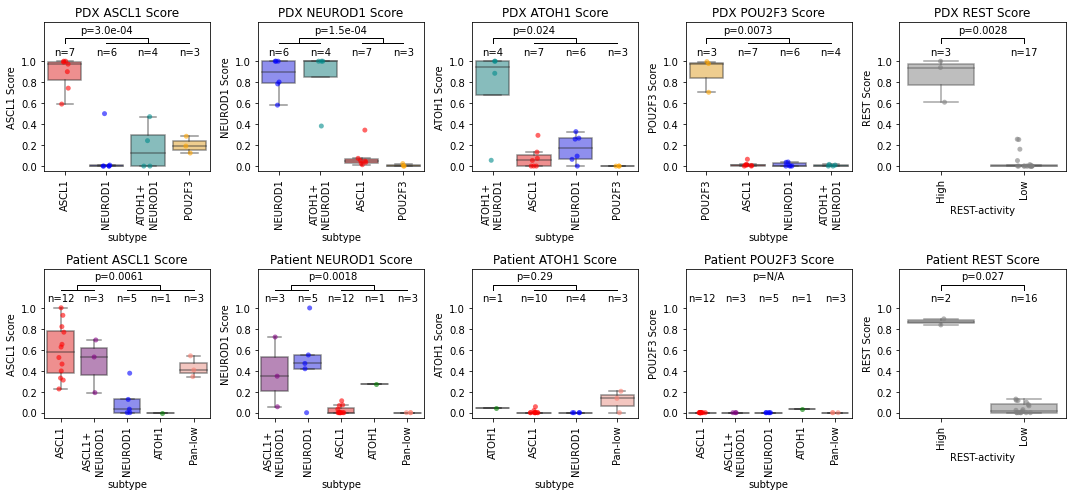

In [13]:
def SN_subtype_box_plots_v2(selected_results):
    fig, ax = plt.subplots(2,5, figsize = (15,7))

    annot_top = 1.17

    #TFs
    a = selected_results[~(selected_results['analysis'].isin(['SCLC-v-NSCLC','REST']))]
    a = a[(a['source']=='pdx') & (a['histology'].isin(['SCLC','LCNEC']))]

    b = selected_results[~(selected_results['analysis'].isin(['SCLC-v-NSCLC','REST']))]
    b = b[(b['source']=='patient') & (b['histology']=='SCLC') & ~(b['subtype']=='Unknown')]


    for i,(source,df1) in enumerate(zip(['PDX','Patient'],[a,b])):
        for j,analysis in enumerate(analysis_order2):

            df2 = df1[(df1['analysis']==analysis)]
            df2 = df2[~(df2[analysis+'-activity']=='Unknown')] #remove IHC samples for factors where IHC wasn't done

            high = [m for m in order if m in df2['subtype'].values and analysis in m]
            low = [m for m in order if m in df2['subtype'].values and not analysis in m]
            current_order = high+low

            colors = pd.Series(current_order).map(color_dict).to_list()

            sns.boxplot(y = df2['s_hat'], x = df2['subtype'], ax = ax[i,j],  
                        showfliers = False, palette = colors, order = current_order,
                        boxprops={"alpha": .5}, whiskerprops={"alpha": .5}, capprops={"alpha": .5}, medianprops={"alpha": .5})

            sns.stripplot(y = df2['s_hat'], x = df2['subtype'], ax = ax[i,j], 
                      palette = colors, size = 5, alpha = 0.6, dodge = True, order = current_order)

            #add stats        
            a = df2[df2['subtype'].isin(high)]['s_hat']
            b = df2[df2['subtype'].isin(low)]['s_hat']
            if len(a)>0 and len(b)>0:
                ax[i,j].plot([0,len(high)-1],[annot_top,annot_top], color = 'black',linewidth = 1)
                ax[i,j].plot([len(high),len(high)+len(low)-1],[annot_top,annot_top], color = 'black', linewidth = 1)
                left = (len(high)-1)/2
                right = ((len(low)-1)/2)+len(high)
                ax[i,j].plot([left,left,right,right],[annot_top, annot_top+.05,annot_top+.05, annot_top], color = 'black', linewidth = 1)

                statistic, pval = mannwhitneyu(a,b)
                if pval<0.001:
                    formatted_pval = 'p={:.1e}'.format(pval)
                else:
                    formatted_pval = 'p={:.2g}'.format(pval)
                ax[i,j].annotate(formatted_pval,[(left+right)/2,annot_top+.1], ha='center')
                #print(analysis,source,len(a),len(b),formatted_pval)
                del(left,right)
                del(statistic,pval,formatted_pval)
            else:
                ax[i,j].annotate('p=N/A',[(len(current_order)-1)/2,annot_top+.1], ha='center')
            del(a,b)


            ax[i,j].set_ylim(-0.05,annot_top + .20) 
            ax[i,j].set_yticks(np.arange(0,1.01,0.2))
            ax[i,j].tick_params(axis = 'x', rotation = 90)
            ax[i,j].set_title(source+' '+analysis+' Score')
            ax[i,j].set_ylabel(analysis+' Score')
            #ax[i,j].axhline(threshold_dict_SCLC[analysis], color = 'tab:grey', alpha = 0.5, dashes = [2,2])

            vals = df2[['sample','subtype']].drop_duplicates().groupby('subtype', sort = False).size().to_dict()
            pos = range(len(ax[i,j].get_xticklabels()))
            for tick,label in zip(pos,ax[i,j].get_xticklabels()):
                ax[i,j].text(pos[tick],
                        1.06,
                        'n='+str(vals[label.get_text()]),
                        horizontalalignment='center',)
            ax[i,j].set_xticklabels([m.replace('+','+\n') for m in current_order])#make the label names two lines for double positive
            del(high,low,current_order)

    #add REST
    pdx_rest = selected_results[(selected_results['analysis'].isin(['REST']))]
    pdx_rest = pdx_rest[(pdx_rest['source']=='pdx') & (pdx_rest['histology'].isin(['SCLC','LCNEC']))]

    pt_rest = selected_results[(selected_results['analysis'].isin(['REST']))]
    pt_rest = pt_rest[(pt_rest['source']=='patient') & (pt_rest['histology']=='SCLC') & ~(pt_rest['REST-activity']=='Unknown')]

    j = 4

    for i,(source,df1) in enumerate(zip(['PDX','Patient'],[pdx_rest,pt_rest])):        
        for analysis,df2 in df1.groupby('analysis', sort = False):

            sns.boxplot(y = df2['s_hat'], x = df2['REST-activity'], ax = ax[i,j],  
                        showfliers = False, color = color_dict['REST'], order = ['High','Low'],
                        boxprops={"alpha": .5}, whiskerprops={"alpha": .5}, capprops={"alpha": .5}, medianprops={"alpha": .5})

            sns.stripplot(y = df2['s_hat'], x = df2['REST-activity'], ax = ax[i,j], order = ['High','Low'],
                      size = 5, alpha = 0.6, dodge = True, color = 'tab:grey')

            #add stats


            a = df2[df2['REST-activity']=='High']['s_hat']
            b = df2[df2['REST-activity']=='Low']['s_hat']
            if len(a)>0 and len(b)>0:
                ax[i,j].plot([0,0,1,1],[annot_top, annot_top+.05,annot_top+.05, annot_top], color = 'black', linewidth = 1)

                statistic, pval = mannwhitneyu(a,b)
                if pval<0.001:
                    formatted_pval = 'p={:.1e}'.format(pval)
                else:
                    formatted_pval = 'p={:.2g}'.format(pval)
                ax[i,j].annotate(formatted_pval,[0.5,annot_top+.1], ha='center')
                #print(analysis,source,len(a),len(b),formatted_pval)
                del(statistic,pval,formatted_pval)
            else:
                ax[i,j].annotate('p=N/A',[(len(current_order)-1)/2,annot_top+.1], ha='center')
            del(a,b)


            ax[i,j].set_ylim(-0.05,annot_top + .20) 
            ax[i,j].set_yticks(np.arange(0,1.01,0.2))
            ax[i,j].tick_params(axis = 'x', rotation = 90)
            ax[i,j].set_title(source+' '+analysis+' Score')
            ax[i,j].set_ylabel(analysis+' Score')
            #ax[i,j].axhline(threshold_dict_SCLC[analysis], color = 'tab:grey', alpha = 0.5, dashes = [2,2])

            #add number of samples
            vals = df2[['sample','REST-activity']].drop_duplicates().groupby('REST-activity', sort = False).size().to_dict()
            pos = range(len(ax[i,j].get_xticklabels()))
            for tick,label in zip(pos,ax[i,j].get_xticklabels()):
                ax[i,j].text(pos[tick],
                        1.06,
                        'n='+str(vals[label.get_text()]),
                        horizontalalignment='center',)


    fig.tight_layout()
    fig.savefig(out_dir+'/SCLC_subtype_box_per_analysis.v2.pdf')

SN_subtype_box_plots_v2(selected_results[(selected_results['tumor_fraction']>=0.05)])


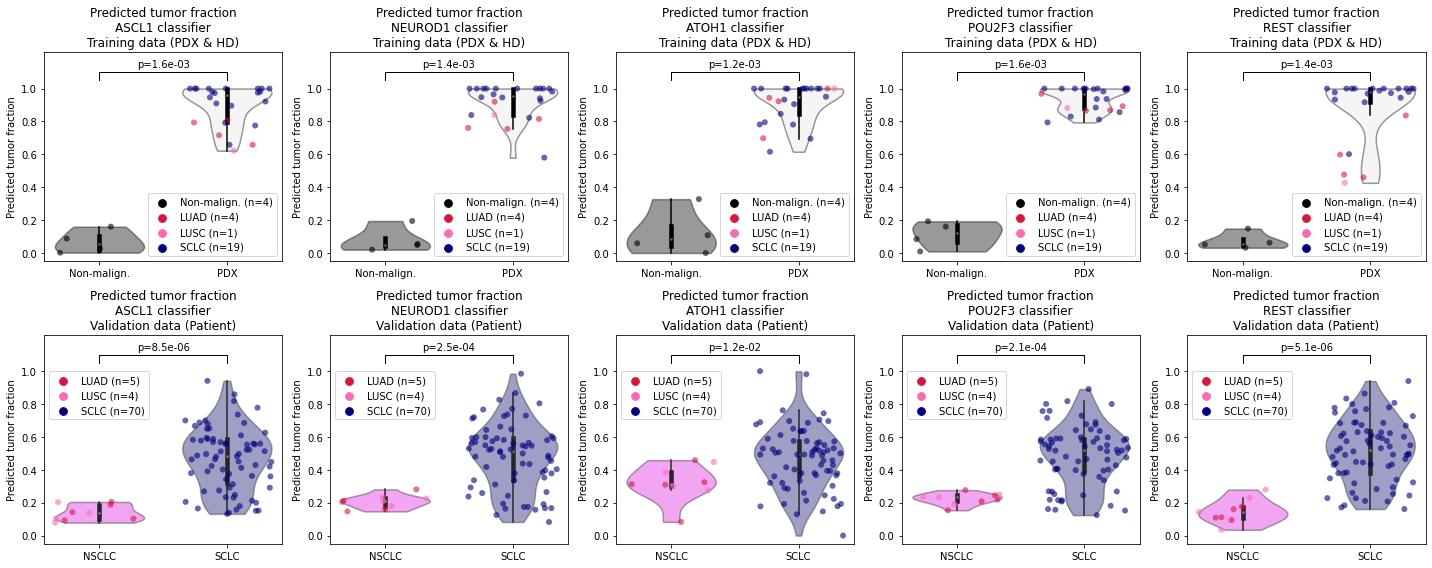

In [14]:
def make_SCLC_tfx_plots(selected_results):
    fig,axes = plt.subplots(2,5, figsize = (20,8))

    width = .7 #violin width
    dot_size = 6
    jitter = 0.35
    np.random.seed(125) #set the random seed for the jitter
    metric = 'a_hat'

    df1 = selected_results[~(selected_results['analysis']=='SCLC-v-NSCLC')]
    #df1 = df1[(df1['histology'].isin(['SCLC','LCNEC','Non-malign.']))]
    df1 = df1[(df1['tumor_fraction']>=0.05) | (df1['histology']=='Non-malign.')]
    df1 = df1.copy()
    df1['group'] = df1['histology'].replace('LUSC','NSCLC').replace('LUAD','NSCLC')
    df1['source'] = np.where(df1['histology']=='Non-malign.',df1['histology'],df1['source'])

    ylabel_dict = {'a_hat':'Predicted tumor fraction'}
    source_label_dict = {'Non-malign.':'Non-malign.','pdx':'PDX','patient':'Patient'}

    #PDX and HD tumor fraction violin plot############################
    for i,TF in enumerate(analysis_order):
        df2 = df1[(df1['source']=='pdx') | (df1['histology']=='Non-malign.')]
        df2 = df2[df2['analysis']==TF]

        ax = axes[0,i]

        box_order = ['Non-malign.', 'pdx']
        box_colors = ['0.0', '0.9']

        scatter_order = ['Non-malign.','LUAD','LUSC','SCLC']
        scatter_colors = [color_dict[m] for m in scatter_order]

        sns.violinplot(x = df2['source'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
        plt.setp(ax.collections, alpha=.4)
        sns.stripplot(x = df2['source'], y = df2[metric], hue = df2['histology'], ax = ax,
                      size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                      hue_order = scatter_order, palette = scatter_colors)

        #add stats
        a = df2[df2['source']=='pdx'][metric]
        b = df2[df2['source']=='Non-malign.'][metric]
        statistic, pval = mannwhitneyu(a,b)
        formatted_pval = 'p={:.1e}'.format(pval)
        ax.annotate(formatted_pval,[0.5,1.13], ha='center')
        ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
        del(statistic,pval,formatted_pval)

        #format plot
        counts = df2['histology'].value_counts().to_dict()
        handles, labels = ax.get_legend_handles_labels()
        labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
        ax.legend(handles,labels,loc = 'lower right')
        ax.set_ylim(-0.05,1.22)
        ax.set_ylabel(ylabel_dict[metric])
        ax.set_xlabel('')
        ax.set_xticklabels([source_label_dict[m] for m in box_order])
        ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
        ax.set_yticks(np.arange(0,1.01,0.2))
        ax.set_title(ylabel_dict[metric]+'\n'+TF+' classifier\nTraining data (PDX & HD)')
        del(df2)
        ##################################################################

        #Patient tumor fraction violin plot###############################
        df2 = df1[(df1['source']=='patient') & (df1['tumor_fraction']>0.05)]
        df2 = df2[df2['analysis']==TF]
        ax = axes[1,i]

        box_order = ['NSCLC', 'SCLC']
        box_colors = [color_dict[m] for m in box_order]

        scatter_order = ['LUAD','LUSC','SCLC']
        scatter_colors = [color_dict[m] for m in scatter_order]

        sns.violinplot(x = df2['group'], y = df2[metric], ax = ax, cut = 0, palette = box_colors, scale = 'width', order = box_order, width = width)
        plt.setp(ax.collections, alpha=.4)
        sns.stripplot(x = df2['group'], y = df2[metric], hue = df2['histology'], ax = ax,
                      size = dot_size, alpha = 0.6, jitter = jitter, order = box_order, 
                      hue_order = scatter_order, palette = scatter_colors)

        #add stats
        a = df2[df2['group']=='NSCLC'][metric]
        b = df2[df2['group']=='SCLC'][metric]
        statistic, pval = mannwhitneyu(a,b)
        formatted_pval = 'p={:.1e}'.format(pval)
        ax.annotate(formatted_pval,[0.5,1.13], ha='center')
        ax.plot([0,0,1,1],[1.05,1.10,1.10, 1.05], color = 'black', linewidth = 1)
        del(statistic,pval,formatted_pval)

        #format plot
        counts = df2['histology'].value_counts().to_dict()
        handles, labels = ax.get_legend_handles_labels()
        labels = [m + ' (n=' + str(counts[m])+')' for m in labels]
        ax.legend(handles,labels,loc = 'upper left', bbox_to_anchor = [0,.85])
        ax.set_ylim(-0.05,1.22)
        ax.set_ylabel(ylabel_dict[metric])
        ax.set_xlabel('')
        ax.tick_params(left = True, labelleft = True, bottom = True, labelbottom = True)
        ax.set_yticks(np.arange(0,1.01,0.2))
        ax.set_title(ylabel_dict[metric]+'\n'+TF+' classifier\nValidation data (Patient)')
        del(df2)
        ##################################################################


    fig.tight_layout()
    fig.savefig(out_dir+'/SCLC_tfx_violin.pdf')

make_SCLC_tfx_plots(selected_results)


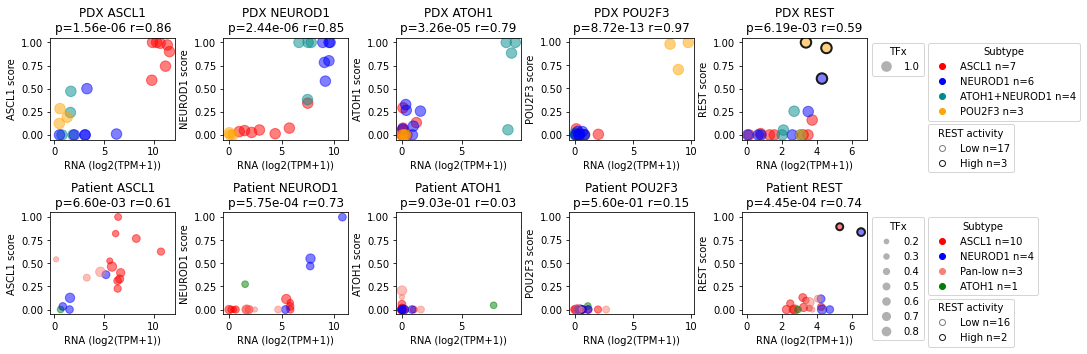

In [15]:
def SCLC_RNA_scatter(selected_results):
    source_label_dict = {'pdx':'PDX','patient':'Patient'}
    REST_line_dict = {'High': 2, 'Low': .1}
    REST_color_dict = {'High': '.1', 'Low': '.5'}
    
    fig,ax = plt.subplots(2,5, figsize = (15,5), sharex = 'col', sharey = 'col')
    for i,source in enumerate(['pdx','patient']):    
        for j,analysis in enumerate(analysis_order):
            target_column = analysis_dict[analysis]['target_column']
            pos_phenos = analysis_dict[analysis]['pos_phenos']
            test_hist = analysis_dict[analysis]['training_histologies']

            df1 = selected_results[(selected_results['source']==source) 
                                   & (selected_results['analysis']==analysis)]        
            df1 = df1[(df1['histology'].isin(test_hist))] #this removes the HDs
            df1 = df1[~(df1[target_column].isin(null_labels))].copy()
            df1 = df1[~(df1[analysis].isnull())] #this removes those without RNA
            df1[analysis] = df1[analysis].astype(float)
            df1 = df1.sort_values(by='subtype')
            df1 = df1.copy()

            df1['size'] = df1['tumor_fraction']*100+10

            #for subtype,df2 in df1.groupby('subtype'):
            scatter = ax[i,j].scatter(df1[analysis], df1['s_hat'], color = df1['subtype'].map(color_dict), 
                            alpha = 0.5, s = df1['size'], label = 'test')
            if analysis == 'REST':
                scatter = ax[i,j].scatter(df1[analysis], df1['s_hat'], facecolor='none', edgecolor = df1['REST-activity'].map(REST_color_dict), 
                                          linewidth = df1['REST-activity'].map(REST_line_dict), s = df1['size'], label = 'test2')

            #run stats
            pearson_r,pval = pearsonr(df1[analysis], df1['s_hat'])
            stat_text = source_label_dict[source]+' '+analysis+'\np={:.2e}'.format(pval)+' r={:.2f}'.format(pearson_r) 

            ax[i,j].set_xlabel('RNA (log2(TPM+1))')
            ax[i,j].set_ylabel(analysis + ' score')
            ax[i,j].tick_params(labelbottom = True, bottom = True)
            ax[i,j].set_title(stat_text)

            #print(len(df1),stat_text)
            
        #legend with marker sizes   
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.3, num = 5)
        labels = [(float(m.split("{")[1].split("}")[0])-10)/100 for m in labels]
        legend1 = ax[i,j].legend(handles, labels, loc="upper left", bbox_to_anchor = [1,1], title="TFx")
        ax[i,j].add_artist(legend1)

        #add subtypes and counts
        legend_elements = []
        for subtype,count in df1['subtype'].value_counts().to_dict().items():
            legend_elements.append(Line2D([0], [0], marker='o',linestyle = '', color=color_dict[subtype], label=subtype+ ' n='+str(count)))
        legend2 = ax[i,j].legend(handles=legend_elements, bbox_to_anchor = [1.45,1], loc = 'upper left', title = 'Subtype')
        ax[i,j].add_artist(legend2)
        
        #add subtypes and counts
        legend_elements = []
        for subtype,count in df1['REST-activity'].value_counts().to_dict().items():
            legend_elements.append(Line2D([0], [0], marker='o',linestyle = '', markeredgecolor=REST_color_dict[subtype],
                                          markerfacecolor = 'None',
                                          label=subtype+ ' n='+str(count)))
        ax[i,j].legend(handles=legend_elements, bbox_to_anchor = [1.45,.2], loc = 'upper left', title = 'REST activity')

    fig.tight_layout()
    fig.subplots_adjust(right = .8)
    fig.savefig(out_dir+'/expression_vs_prediction.pdf')
    fig.show()

SCLC_RNA_scatter(selected_results[(selected_results['tumor_fraction']>=0.05)])

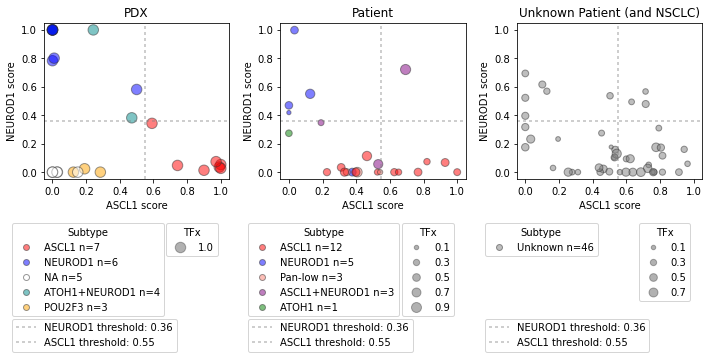

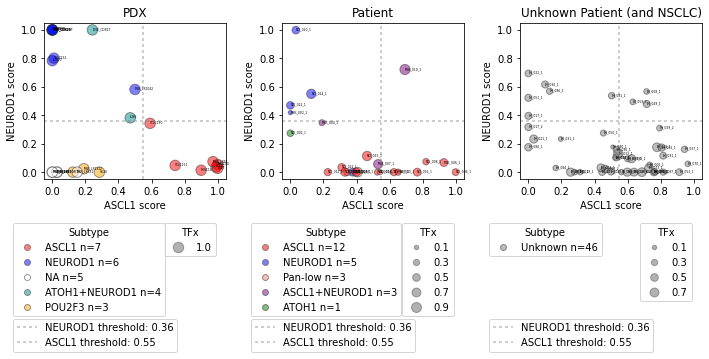

In [16]:
def ASCL1_vs_NEUROD1(selected_results,text_on):           
    fig,ax = plt.subplots(1,3, figsize = (10,5))
    
    df1 = selected_results[selected_results['analysis'].isin(['ASCL1','NEUROD1'])]
    df1 = df1.set_index(['sample','sample_name','result_type','source','histology','subtype','tumor_fraction','analysis'])[['s_hat']].unstack()
    df1 = df1.reset_index()
    df1['size'] = df1['tumor_fraction']*100+10

    color_dict_temp = color_dict.copy()
    color_dict_temp['Unknown'] = 'tab:grey'
    
    a = df1[(df1['source']=='pdx')].copy()
    b = df1[(df1['result_type']=='test') & ~(df1['subtype'].isin(['Unknown','NA']))].copy()
    #take out NSCLC from this plot for revisions#c = df1[(df1['result_type']=='test') &  (df1['subtype'].isin(['Unknown','NA']))].copy()
    c = df1[(df1['result_type']=='test') &  (df1['subtype'].isin(['Unknown']))].copy()
    
    
    for i,(group,df2) in enumerate(zip(['PDX','Patient','Unknown Patient (and NSCLC)'],[a,b,c])):
        scatter = ax[i].scatter(df2[('s_hat','ASCL1')],df2[('s_hat','NEUROD1')],
                      color = df2['subtype'].map(color_dict_temp), s = df2['size'],
                      alpha = 0.5, edgecolor = '.2')
        if text_on:
            for j in range(len(df2)):
                df3 = df2.iloc[j]
                ax[i].text(df3[('s_hat','ASCL1')], df3[('s_hat','NEUROD1')], s = df3['sample_name'].values[0], size = 3)

        ax[i].set_title(group)
        ax[i].set_xlabel('ASCL1 score')
        ax[i].set_ylabel('NEUROD1 score')
        ax[i].set_xlim(-0.05,1.05)
        ax[i].set_ylim(-0.05,1.05)
        
        
        # legend with marker sizes     
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.3, num = 5)
        labels = [(float(m.split("{")[1].split("}")[0])-10)/100 for m in labels]
        legend1 = ax[i].legend(handles, labels, loc="upper left", bbox_to_anchor = [.63,-0.25], title="TFx")
        ax[i].add_artist(legend1)
        ax[i].axhline(threshold_dict_SCLC['NEUROD1'], dashes = [2,2], alpha = 0.5, color = 'tab:grey', label = 'NEUROD1 threshold: '+str(threshold_dict_SCLC['NEUROD1']))
        ax[i].axvline(threshold_dict_SCLC['ASCL1'], dashes = [2,2], alpha = 0.5, color = 'tab:grey', label = 'ASCL1 threshold: '+str(threshold_dict_SCLC['ASCL1']))
        legend2 = ax[i].legend(bbox_to_anchor = [-0.2,-.86],loc = 'upper left')
        ax[i].add_artist(legend2)
        #add subtypes and counts
        legend_elements = []
        for subtype,count in df2['subtype'].value_counts().to_dict().items():
            legend_elements.append(Line2D([0], [0], marker='o',linestyle = '', markeredgecolor = '0.2', alpha = .5, color=color_dict_temp[subtype], label=subtype+ ' n='+str(count)))
        ax[i].legend(handles=legend_elements, bbox_to_anchor = [-0.2,-0.25], loc = 'upper left', title = 'Subtype')
        
        
    fig.tight_layout()
    if not text_on:
        fig.savefig(out_dir+'/ASCL1_vs_NEUROD1.pdf')
    if text_on:
        fig.savefig(out_dir+'/ASCL1_vs_NEUROD1_with_labels.pdf')
        
#plot with and without text
ASCL1_vs_NEUROD1(selected_results[selected_results['tumor_fraction']>=0.05], False)
ASCL1_vs_NEUROD1(selected_results[selected_results['tumor_fraction']>=0.05], True)


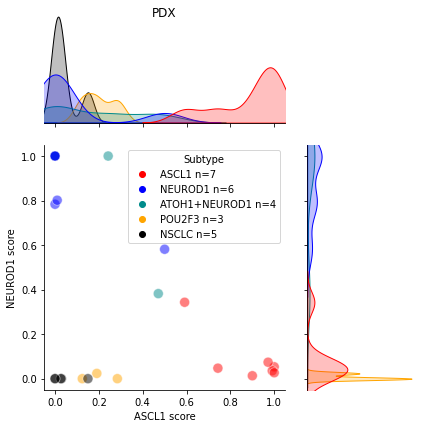

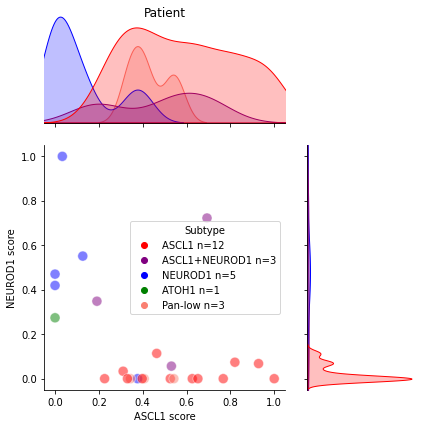

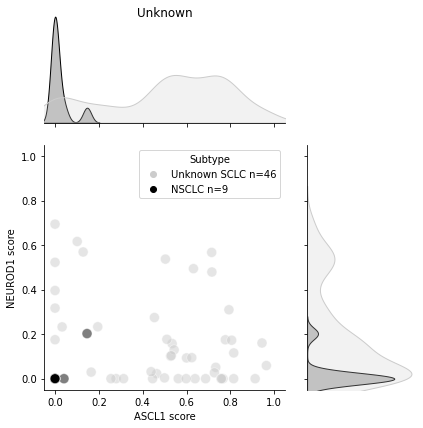

In [17]:
def ASCL1_vs_NEUROD1_joinplot(selected_results):           
    df1 = selected_results[selected_results['analysis'].isin(['ASCL1','NEUROD1'])]
    df1 = df1[df1['tumor_fraction']>0.05]
    df1 = df1.set_index(['sample','sample_name','result_type','source','histology','subtype','tumor_fraction','analysis'])[['s_hat']].unstack()
    df1 = df1.reset_index()
    df1['size'] = df1['tumor_fraction']*100+10


    a = df1[(df1['source']=='pdx')].copy()
    b = df1[(df1['result_type']=='test') & ~(df1['subtype'].isin(['Unknown','NA']))].copy()
    c = df1[(df1['result_type']=='test') &  (df1['subtype'].isin(['Unknown','NA']))].copy()

    # fig,ax = plt.subplots(1,3, figsize = (10,5))
    for df2,source in zip([a,b,c],['PDX','Patient','Unknown']):

        color_dict2 = color_dict.copy()
        color_dict2['NA'] = 'black'
        color_dict2['Unknown'] = '.8'
        current_hue_order = [m for m in order if m in df2['subtype'].values]
        g = sns.jointplot(data=df2, x=('s_hat','ASCL1'), y=('s_hat','NEUROD1'), hue = 'subtype', 
                          hue_order = current_hue_order, palette = [color_dict2[m] for m in current_hue_order],
                         alpha = 0.5, xlim = (-0.05,1.05), ylim = (-0.05,1.05),
                         ratio = 2, s = 100, marginal_kws = {'bw_adjust':0.6,})

        handles, labels = g.ax_joint.get_legend_handles_labels()
        labels = list(pd.Series(labels).replace('NA','NSCLC').replace('Unknown','Unknown SCLC'))

        counts = df2['subtype'].value_counts().to_dict()
        if 'NA' in counts.keys():
            counts['NSCLC'] = counts['NA']
        if 'Unknown' in counts.keys():
            counts['Unknown SCLC'] = counts['Unknown']

        labels = [m+' n='+str(counts[m]) for m in labels]

        legend_dict = dict(zip(labels,handles))
        legend1 = g.ax_joint.legend(legend_dict.values(), legend_dict.keys(), title="Subtype")
        g.ax_joint.set_xlabel('ASCL1 score')
        g.ax_joint.set_ylabel('NEUROD1 score')
        g.ax_marg_x.set_title(source, y = 0.9)

        plt.savefig(out_dir+'/ASCL1_vs_NEUROD1_kde.'+source+'.pdf')
        
ASCL1_vs_NEUROD1_joinplot(selected_results[selected_results['tumor_fraction']>=0.05])

In [18]:
#from COMUT github
def get_triangles(x_base, y_base, tri_padding, height, width):
    '''Returns np arrays of triangle coordinates
    Params:
    -------
    x_base, y_base: floats
        The x and y coordinates of the base of the triangle
    tri_padding: float
        The space between triangles
    height, width: float
        Height and width of the box enclosing the triangles.
    Returns:
    --------
    (tri_1_coords, tri_2_coords): tuple of np arrays
        Tuple of triangle coordinates as np arrays.'''

    tri_1_coords = [[x_base, y_base + tri_padding],
                    [x_base, y_base + height],
                    [x_base + width - tri_padding, y_base + height]]

    tri_2_coords = [[x_base + tri_padding, y_base],
                    [x_base + width, y_base],
                    [x_base + width, y_base + height - tri_padding]]

    return (np.array(tri_1_coords), np.array(tri_2_coords))

In [19]:
#from this stack overflow answer:
# https://stackoverflow.com/questions/65740206/how-to-make-custom-legend-markers-ie-right-angle-triangles-in-matplotlib
class DoubleTriangle:
    def __init__(self, color_left, color_right):
        self.color_left = color_left
        self.color_right = color_right

class DoubleTriangleHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x, y = handlebox.xdescent + handlebox.width/2, handlebox.ydescent
        w, h = 10,10 #handlebox.height, handlebox.height
        gap = h / 8
        
        triangle_left = patches.Polygon([[x, y + gap], [x, y + h], [x + w - gap, y + h]],
                                         facecolor=orig_handle.color_left,
                                         transform=handlebox.get_transform())
        triangle_right = patches.Polygon([[x + gap, y], [x + w, y + h - gap], [x + w, y]],
                                          facecolor=orig_handle.color_right,
                                          transform=handlebox.get_transform())
        handlebox.add_artist(triangle_left)
        handlebox.add_artist(triangle_right)
        return triangle_left, triangle_right


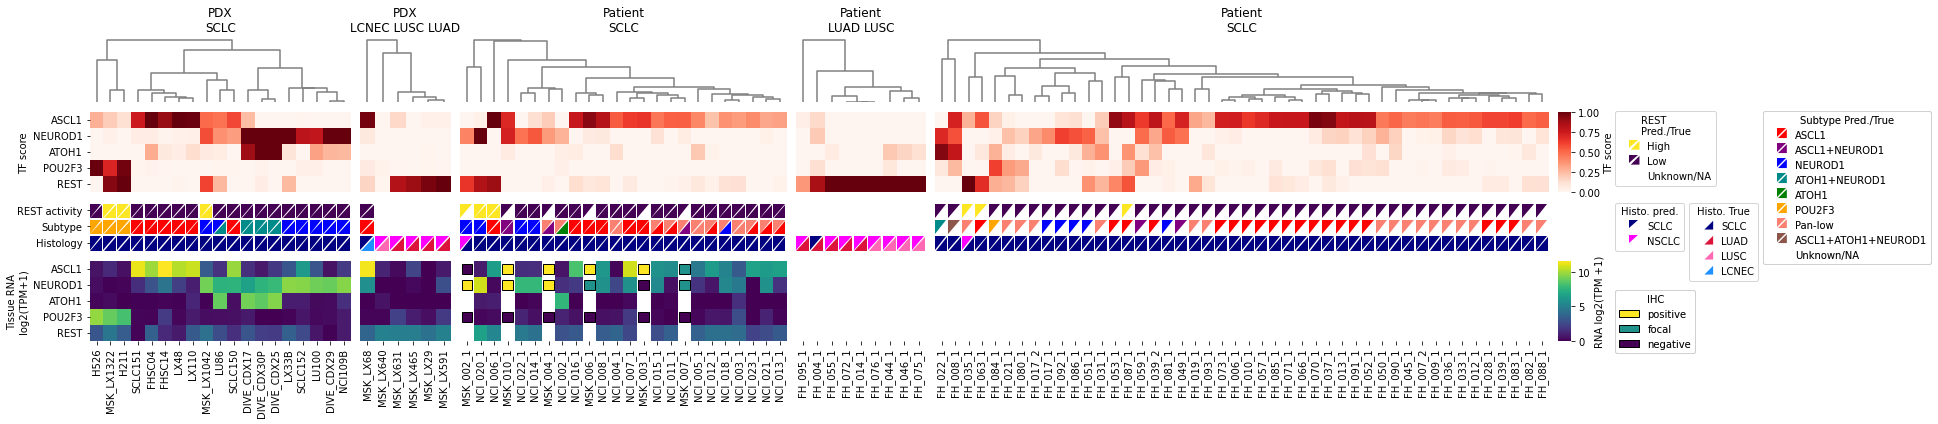

In [20]:
def make_heatmap_v4(threshold_dict_NSCLC,threshold_dict_SCLC):
    index_cols = ['sample','sample_name','source','tumor_fraction','subtype','histology',
                  'ASCL1','NEUROD1','POU2F3','ATOH1','REST',
                  'ASCL1_IHC', 'NEUROD1_IHC', 'POU2F3_IHC', 'YAP1_IHC',
                  'REST-activity', 'ASCL1-activity', 'NEUROD1-activity','POU2F3-activity', 'ATOH1-activity',
                 'analysis']
    title_dict = {'pdx':'PDX','patient':'Patient'}
    ylabel_dict = {'REST-activity':'REST activity','subtype':'Subtype','histology':'Histology'}
    histo_order = ['SCLC', 'LUAD', 'LUSC', 'LCNEC']
    histo_pred_order = ['SCLC','NSCLC']
    REST_order = ['High', 'Low', 'Unknown/NA']
    subtype_order = ['ASCL1', 'ASCL1+NEUROD1', 'NEUROD1', 'ATOH1+NEUROD1','ATOH1','POU2F3', 'Pan-low', 'ASCL1+ATOH1+NEUROD1', 'Unknown/NA']

    df1 = selected_results.set_index(index_cols)[['s_hat']].unstack()#.reset_index()
    df1.columns = ['.'.join(m) for m in df1.columns]
    df1 = df1.reset_index().set_index('sample_name')
    df1 = df1[(df1['tumor_fraction']>=0.05)]
    #df1 = df1[(df1['subtype']!='Unknown')]
    df1 = df1.copy()

    df1['plot_group'] = np.where((df1['source']=='pdx') & (df1['histology']=='SCLC'),0,10)
    df1['plot_group'] = np.where((df1['source']=='pdx') & ~(df1['histology']=='SCLC'),1,df1['plot_group'])
    df1['plot_group'] = np.where((df1['source']=='patient') & (df1['histology']=='SCLC'),2,df1['plot_group'])
    df1['plot_group'] = np.where((df1['source']=='patient') & ~(df1['histology']=='SCLC'),3,df1['plot_group'])
    df1['plot_group'] = np.where((df1['subtype']=='Unknown'),4,df1['plot_group'])


    df1 = df1.sort_values(by ='plot_group')

    #generate prediction columns
    df1['REST-activity_pred'] = np.where(df1['s_hat.REST']>=threshold_dict_SCLC['REST'],'High','Low')
    df1['REST-activity_pred'] = np.where(df1['histology'].isin(['LUAD','LUSC']),'NA',df1['REST-activity_pred']) #remove NSCLC subtype predictions
    df1['REST-activity'] = np.where(df1['histology'].isin(['LUAD','LUSC']),'NA',df1['REST-activity']) #remove NSCLC REST activity from plot

    for analysis in analysis_order2:
        df1[analysis+'_pred'] = np.where(df1['s_hat.'+analysis]>=threshold_dict_SCLC[analysis],1,0)
    pred_subtypes = []
    for k in range(len(df1)):
        df3 = df1[[m+'_pred' for m in sorted(analysis_order2)]].iloc[k]
        pred_subtypes.append("+".join([m.split('_pred')[0] for m in df3[df3!=0].index]))
    df1['subtype_pred'] = pred_subtypes
    df1['subtype_pred'] = df1['subtype_pred'].replace('','Pan-low')
    df1['subtype_pred'] = np.where(df1['histology'].isin(['LUAD','LUSC']),'NA',df1['subtype_pred']) #remove NSCLC subtype predictions
    del(pred_subtypes)

    df1['histology_pred'] = np.where(df1['s_hat.SCLC-v-NSCLC']>=threshold_dict_NSCLC['SCLC-v-NSCLC'],'SCLC','NSCLC')

    #set up legend dicts
    IHC_legend_elements = {}
    prediction_legend_elements = {}


    fig,axes = plt.subplots(4,df1.groupby('plot_group').size().size+1, figsize = (27,6), gridspec_kw={'height_ratios':(4,5,3,5), 
                                                                                                      'width_ratios': list(df1.groupby('plot_group').size().values+1)+ [1]})

    for j in [0,2]: #remove the extra ax that is making space for the legend
        fig.delaxes(axes[j,-1])



    for i,df2 in df1.groupby('plot_group'):
        df2 = df2.copy()

        #dendrogram###################
        j = 0
        ax = axes[j,i]
        linkage = hierarchy.linkage(df2[prediction_cols], method='average', metric='euclidean', optimal_ordering=False)
        dendrogram = hierarchy.dendrogram(linkage, labels = df2.index, ax=ax, color_threshold=0, above_threshold_color='tab:grey');
        ax.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)
        for edge in ['top','right','bottom','left']:
            ax.spines[edge].set_visible(False)
        ax.set_xlabel('')
        ax.set_title(' '.join(df2['source'].map(title_dict).unique())+'\n'+' '.join(df2['histology'].unique()))
        ##############################

        #prediction scores##################
        j += 1
        ax = axes[j,i]
        sns.heatmap(df2.loc[dendrogram['ivl']][prediction_cols].T, ax = ax, cbar = True, cbar_ax = axes[j,-1], cbar_kws = {'label':'TF score'}, 
                    vmin = 0, vmax = 1, cmap = 'Reds')
        ax.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
        ax.set_xlabel('')  
        ax.set_yticklabels([m.split('.')[1] for m in prediction_cols])
        axes[j,0].tick_params(left = True, labelleft = True)
        axes[j,0].set_ylabel('TF score')
        ##############################

        ##prediction triangles#############
        j += 1
        ax = axes[j,i]

        #plot predictions and ground truth
        left_pad = 0
        tri_padding = .05
        height = 0.9
        width = 0.9
        analyses_list = ['histology','subtype','REST-activity']
        y_ticks = []
        y_tick_labels = []

        for y_base, analysis in enumerate(analyses_list):
            for k,sample_name in enumerate(dendrogram['ivl']):
                tri_1, tri_2 = get_triangles(k+left_pad, y_base, tri_padding,
                                                                 height, width)
                subtype_pred = df2.loc[sample_name][analysis+'_pred']
                subtype_truth = df2.loc[sample_name][analysis]
                tri_1_patch = patches.Polygon(tri_1, facecolor = color_dict[subtype_pred], label = subtype_pred)
                tri_2_patch = patches.Polygon(tri_2, facecolor = color_dict[subtype_truth], label = subtype_truth)

                ax.add_patch(tri_1_patch)
                ax.add_patch(tri_2_patch) 
            y_ticks.append(y_base+0.5)
            y_tick_labels.append(ylabel_dict[analysis])

        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)    
        ax.set_xlim(0,len(df2))
        ax.set_ylim(0,len(analyses_list))    
        ax.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
        ax.set_xlabel('')  
        for edge in ['top','right','bottom','left']:
            ax.spines[edge].set_visible(False)
        axes[j,0].tick_params(left = True, labelleft = True)

        #generate legends
        handles,labels = ax.get_legend_handles_labels()
        new_prediction_legend_elements = dict(zip(labels, handles))
        prediction_legend_elements.update(new_prediction_legend_elements)
        if i == axes.shape[1]-2: #if it is the second to last axis, make the legend
            prediction_legend_elements['Unknown/NA'] = prediction_legend_elements['Unknown']

            REST_legend = axes[j,i].legend([DoubleTriangle(color_dict[m], color_dict[m]) for m in REST_order],
                                                 REST_order, handler_map={DoubleTriangle: DoubleTriangleHandler()},
                                                 title = 'REST\nPred./True', bbox_to_anchor = [1.1,3], loc = 'upper left')
            axes[j,i].add_artist(REST_legend)


            histo_pred_legend = axes[j,i].legend([DoubleTriangle(color_dict[m], 'white') for m in histo_pred_order],
                                                 histo_pred_order, handler_map={DoubleTriangle: DoubleTriangleHandler()},
                                                 title = 'Histo. pred.', bbox_to_anchor = [1.1,1.1], loc = 'upper left')
            axes[j,i].add_artist(histo_pred_legend)


            histo_truth_legend = axes[j,i].legend([DoubleTriangle('white', color_dict[m]) for m in histo_order],
                                                 histo_order, handler_map={DoubleTriangle: DoubleTriangleHandler()},
                                                 title = 'Histo. True', bbox_to_anchor = [1.22,1.1], loc = 'upper left')
            axes[j,i].add_artist(histo_truth_legend)

            subtype_legend = axes[j,i].legend([DoubleTriangle(color_dict[m], color_dict[m]) for m in subtype_order],
                                                 subtype_order, handler_map={DoubleTriangle: DoubleTriangleHandler()},
                                                 title = 'Subtype Pred./True', bbox_to_anchor = [1.34,3], loc = 'upper left')
            axes[j,i].add_artist(subtype_legend)
        ##############################

        #RNA##########################
        j += 1
        ax = axes[j,i]
        max_val = df1[RNA_cols].astype(float).max().max()
        heatmap = sns.heatmap(df2.loc[dendrogram['ivl']][RNA_cols].astype(float).T, ax = ax, 
                    cbar = True, cbar_ax = axes[j,-1], cbar_kws = {'label':'RNA log2(TPM +1)'},
                    vmin = 0, vmax = max_val, xticklabels = True, cmap = 'viridis')
        axes[j,0].tick_params(left = True, labelleft = True)
        axes[j,0].set_ylabel('Tissue RNA\nlog2(TPM+1)')
        ax.set_xlabel('') 
        ax.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)

        #Add IHC
        step,space = -1, 0.4
        for k,sample in enumerate(dendrogram['ivl']):
            if sample.startswith('MSK') and df2.loc[sample]['source']=='patient':
                bottom=0.8
                for TF in RNA_cols: 
                    if TF+'_IHC' in df2.columns:
                        activity = df2[TF+'_IHC'].loc[sample]
                        color = color_dict[activity]
                        ax.bar(x=k+.5, height=step+space, bottom = bottom, color = color, width = .8, edgecolor = 'black', label = activity)
                    bottom -= step
        handles,labels = ax.get_legend_handles_labels()
        new_IHC_legend_elements = dict(zip(labels, handles))
        IHC_legend_elements.update(new_IHC_legend_elements)
        if i == axes.shape[1]-2: #if it is the second to last axis, make the legend
            IHC_legend = ax.legend([IHC_legend_elements[m] for m in ['positive','focal','negative']], ['positive','focal','negative'], 
                                   bbox_to_anchor = [1.1,.7], loc = 'upper left', title = 'IHC')
            axes[j,i].add_artist(IHC_legend)

        ##############################

        #for the final axis###########
        ax.tick_params(bottom = True, labelbottom = True)
        ax.tick_params(axis = 'x', rotation = 90)
        ax.set_xticks(np.arange(0.5,len(df2),1))
        ax.set_xticklabels(dendrogram['ivl'])

    fig.tight_layout()
    fig.subplots_adjust(right = .81, hspace = .15)
    fig.savefig(out_dir+'/subtype_heatmap_v4.pdf')

make_heatmap_v4(threshold_dict_NSCLC,threshold_dict_SCLC)


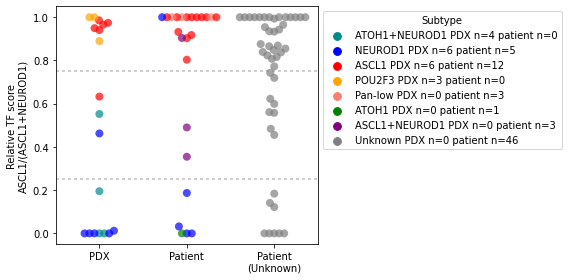

In [21]:
def ASCL1_vs_NEUROD1_relative_score(selected_results):           
    df1 = selected_results[selected_results['analysis'].isin(['ASCL1','NEUROD1'])]
    df1 = df1[df1['tumor_fraction']>0.05]
    df1 = df1[df1['histology'].isin(['SCLC','NSCLC'])]
    df1 = df1.set_index(['sample','sample_name','result_type','source','histology','subtype','tumor_fraction','analysis'])[['s_hat']].unstack()
    df1 = df1.reset_index()

    a = df1[(df1['source']=='pdx')].copy()
    b = df1[(df1['result_type']=='test') & ~(df1['subtype'].isin(['Unknown','NA']))].copy()
    c = df1[(df1['result_type']=='test') &  (df1['subtype'].isin(['Unknown','NA']))].copy()
    a['group'] = a['source']
    b['group'] = b['source']
    c['group'] ='Unknown patient'

    df2 = a.append(b).append(c)

    del(df1,a,b,c)
    df2['Relative TF score'] = df2[('s_hat','ASCL1')]/(df2[('s_hat','ASCL1')]+df2[('s_hat','NEUROD1')])

    palette = df2[('subtype','')].map(color_dict).drop_duplicates()
    palette = palette.replace('white','tab:grey')
    fig,ax = plt.subplots(figsize = (8,4))
    g = sns.swarmplot(x = df2['group'], y = df2[('Relative TF score','')], hue = df2[('subtype','')], palette = palette, 
                  ax = ax, s = 8, alpha = .7)

    ax.set_ylabel('Relative TF score\nASCL1/(ASCL1+NEUROD1)')
    ax.set_xlabel('')
    ax.set_xticklabels(['PDX','Patient','Patient\n(Unknown)'])

    ax.axhline(.75, color = 'tab:grey', alpha = 0.5, dashes = [2,2])
    ax.axhline(.25, color = 'tab:grey', alpha = 0.5, dashes = [2,2])

    #custom legend
    counts = pd.DataFrame(df2[['source','subtype']].value_counts()).unstack().fillna(0).stack()
    counts.index = ['_'.join(m) for m in counts.index]
    counts = counts.T
    counts = counts.astype(int)
    handles, labels = g.get_legend_handles_labels()
    labels = [m+' PDX n='+str(counts['pdx_'+m].values[0])+' patient n='+str(counts['patient_'+m].values[0]) for m in labels]
    legend_dict = dict(zip(labels,handles))
    legend1 = g.legend(legend_dict.values(), legend_dict.keys(), title="Subtype",
                      bbox_to_anchor = [1,1], loc = 'upper left')

    fig.tight_layout()
    plt.savefig(out_dir+'/ASCL1_vs_NEUROD1_relative.pdf')
        
ASCL1_vs_NEUROD1_relative_score(selected_results[selected_results['tumor_fraction']>=0.05])

In [22]:
selected_results[(selected_results['analysis']=='SCLC-v-NSCLC') & (selected_results['source']=='pdx') & (selected_results['result_type']=='training')]['a_hat'].median()

0.9945038401465304

In [23]:
selected_results[(selected_results['analysis']=='SCLC-v-NSCLC') & (selected_results['histology']=='Non-malign.') & (selected_results['result_type']=='training')]['a_hat'].median()


0.053575233541170705

In [24]:
for TF in ['ASCL1', 'POU2F3','ATOH1']:
    print(TF)
    for activity in ['High','Low']:
        df1 = selected_results[(selected_results['tumor_fraction']>=0.05) &
                               (selected_results['analysis']==TF) & 
                               (selected_results['source']=='patient') & 
                               (selected_results['histology']=='SCLC') & 
                               (selected_results[TF+'-activity']==activity)]
        if len(df1)>0:
            print(activity+' n='+str(len(df1)), 'median: '+str(np.round(df1['s_hat'].median(),3)), 'IQR: '+str(np.round(np.percentile(df1['s_hat'],25), 3))+'-'+str(np.round(np.percentile(df1['s_hat'],75), 3)))
    
    

ASCL1
High n=15 median: 0.531 IQR: 0.364-0.73
Low n=9 median: 0.126 IQR: 0.0-0.376
POU2F3
Low n=24 median: 0.0 IQR: 0.0-0.0
ATOH1
High n=1 median: 0.046 IQR: 0.046-0.046
Low n=17 median: 0.0 IQR: 0.0-0.0


In [25]:
for TF in ['ASCL1','NEUROD1','POU2F3','ATOH1','REST']:
    print(TF)
    for activity in ['High','Low']:
        df1 = selected_results[(selected_results['tumor_fraction']>=0.05) &
                               (selected_results['analysis']==TF) & 
                               (selected_results['source']=='patient') & 
                               (selected_results['histology'].isin(['LUAD','LUSC'])) & 
                               (selected_results[TF+'-activity']==activity)]
        if len(df1)>0:
            print(activity+' n='+str(len(df1)), 'median: '+str(np.round(df1['s_hat'].median(),3)), 'IQR: '+str(np.round(np.percentile(df1['s_hat'],25), 3))+'-'+str(np.round(np.percentile(df1['s_hat'],75), 3)))


ASCL1
Low n=9 median: 0.0 IQR: 0.0-0.0
NEUROD1
Low n=9 median: 0.0 IQR: 0.0-0.0
POU2F3
Low n=9 median: 0.0 IQR: 0.0-0.0
ATOH1
Low n=9 median: 0.0 IQR: 0.0-0.122
REST
High n=9 median: 1.0 IQR: 1.0-1.0


In [26]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/